In [1]:
import pandas as pd
import glob, re, os
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import f_oneway

**Mount Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Preparation**

In [3]:
# Import necessary libraries / 必要なライブラリのインポート
import pandas as pd  # For data handling / データ操作用
import numpy as np  # For numerical operations / 数値処理用
from sklearn.preprocessing import StandardScaler  # For feature scaling / 特徴量の標準化

# Load CSV containing player stats and small_class labels
# 選手スタッツとsmall_classラベルを含むCSVを読み込み
df = pd.read_csv('/content/drive/MyDrive/MIT_Sloan/position_stats_mean_per_min_small_class.csv')

# Convert duration from timedelta to minutes
# 出場時間（timedelta型）を分に変換
df['duration_minutes'] = pd.to_timedelta(df['duration']).dt.total_seconds() / 60

# Define list of stats to normalize per minute
# 1分あたりに正規化するスタッツ項目を定義
stats_to_normalize = [
    'pass_CA', 'pass_HS', 'pass_SA',
    'carry_CA', 'carry_HS', 'carry_SA',
    'short_pass_side_attempt', 'short_pass_side_success',
    'short_pass_central_attempt', 'short_pass_central_success',
    'long_pass_attempts', 'long_pass_success',
    'vertical_pass_success', 'switch_pass_count',
    'cross_count', 'dribble_attempts', 'dribble_success',
    'pocket_entry', 'carry_into_PA', 'action_in_PA',
    'shot_count', 'xG_total'
]

# Remove rows where position_name is 'substitutions'
# 'substitutions' の行を除外（分析対象外）
df = df[df['position_name'] != 'substitutions']

# Normalize each stat per minute (fill NaN with 0)
# 各スタッツを1分あたりに換算（NaNは0で置換）
for stat in stats_to_normalize:
    df[f'{stat}_per_min'] = df[stat].fillna(0) / df['duration_minutes']

# Create list of normalized feature column names
# 正規化された特徴量列名一覧を作成
features = [f'{stat}_per_min' for stat in stats_to_normalize]

# Standardize features using sklearn
# sklearnを用いて特徴量を標準化
scaler = StandardScaler()
X_stats = scaler.fit_transform(df[features].fillna(0))

# Display sample of normalized features
# 正規化されたスタッツのサンプルを表示
print(df[[f'{stat}_per_min' for stat in stats_to_normalize]].head())

# Save processed DataFrame to CSV
# 処理済みのDataFrameをCSVとして保存
df.to_csv('/content/drive/MyDrive/position_stats_mean_per_min_small_class.csv', index=False)


   pass_CA_per_min  pass_HS_per_min  pass_SA_per_min  carry_CA_per_min  \
0         0.299103         0.119641         0.029910          0.898398   
1         0.039880         0.209372         0.329013          0.105702   
2         0.166564         0.314621         0.111043          0.239370   
3         0.069791         0.219342         0.558325          0.778774   
4         0.012876         0.038627         0.347639          0.000000   

   carry_HS_per_min  carry_SA_per_min  short_pass_side_attempt_per_min  \
0          0.613177          0.039992                         0.000000   
1          0.654806          1.460897                         0.239282   
2          2.462876          0.000000                         0.111043   
3          1.225922          1.236597                         0.229312   
4          0.647597          0.991355                         0.077253   

   short_pass_side_success_per_min  short_pass_central_attempt_per_min  \
0                         0.000000  

**Random Forest: Data Loading and Preparation (データの読み込みと準備)**

In [4]:
# Import necessary libraries / 必要なライブラリのインポート
import pandas as pd  # For data handling / データ操作用
from sklearn.model_selection import train_test_split  # For splitting data / データ分割用
from sklearn.ensemble import RandomForestClassifier  # Random Forest model / ランダムフォレストモデル
from sklearn.preprocessing import LabelEncoder  # For label encoding / ラベルの数値化
from sklearn.metrics import classification_report, confusion_matrix  # For evaluation / モデル評価用
import matplotlib.pyplot as plt  # For plotting / グラフ描画用
import seaborn as sns  # For heatmap visualization / ヒートマップ描画用

# Load CSV file containing player stats and small_class labels
# 選手スタッツとsmall_classラベルを含むCSVファイルを読み込み
df = pd.read_csv('/content/drive/MyDrive/MIT_Sloan/position_stats_mean_per_min_small_class.csv')

# Remove rows with missing small_class values
# small_classが欠損している行を除外
df = df.dropna(subset=['small_class'])

# Encode target variable (small_class) into numeric labels
# 目的変数（small_class）を数値ラベルに変換
le = LabelEncoder()
df['target'] = le.fit_transform(df['small_class'])

# Extract feature columns ending with '_per_min'
# '_per_min'で終わる列を説明変数として抽出
feature_cols = [col for col in df.columns if col.endswith('_per_min')]
X = df[feature_cols]  # Features / 説明変数
y = df['target']      # Target / 目的変数

# Fill missing values with 0 (if any)
# 欠損値を0で補完（必要に応じて）
X = X.fillna(0)

# Split data into training and testing sets
# データを学習用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**Model Training and Evaluation (モデルの学習と評価)**

In [5]:
# Train a Random Forest classifier / ランダムフォレスト分類器の学習
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # 100本の決定木を使用
rf.fit(X_train, y_train)  # 学習データでモデルを訓練

# Display class labels / クラスラベル（ポジション名）を表示
print("target_names:", le.classes_)  # ラベルエンコーダで変換されたクラス名を表示

# Predict and evaluate / 予測と評価
y_pred = rf.predict(X_test)  # テストデータに対する予測を実行

# Print classification report / 分類レポートを表示
print("📊 Classification Report / 分類レポート:")
print(classification_report(y_test, y_pred, target_names=le.classes_))  # 各クラスの精度指標を表示

# Print confusion matrix / 混同行列を表示
print("🧩 Confusion Matrix / 混同行列:")


target_names: ['CMF' 'GK' 'LCB' 'LFB' 'LWB' 'LWG' 'RCB' 'RFB' 'RWB' 'RWG' 'ST']
分類レポート:
              precision    recall  f1-score   support

         CMF       0.57      0.78      0.66       113
          GK       0.93      1.00      0.96        26
         LCB       0.38      0.32      0.35        31
         LFB       0.48      0.45      0.46        29
         LWB       0.00      0.00      0.00        12
         LWG       0.20      0.22      0.21        27
         RCB       0.46      0.21      0.29        29
         RFB       0.29      0.47      0.36        17
         RWB       1.00      0.08      0.14        13
         RWG       0.37      0.24      0.29        45
          ST       0.43      0.43      0.43        23

    accuracy                           0.49       365
   macro avg       0.46      0.38      0.38       365
weighted avg       0.49      0.49      0.46       365

混同行列:
[[88  0  5  0  0  3  2  0  0  5 10]
 [ 0 26  0  0  0  0  0  0  0  0  0]
 [13  2 10  0  0  0  

**Random Forest Performance Metrics (ランダムフォレスト　精度表)**

In [6]:
# Import necessary libraries / 必要なライブラリのインポート
from sklearn.metrics import classification_report  # For generating performance metrics / 精度指標の生成
import pandas as pd  # For DataFrame handling / データフレーム操作

# Define class names (11 football positions)
# クラス名（11ポジション）を定義
target_names = ['CMF', 'GK', 'LCB', 'LFB', 'LWB', 'LWG', 'RCB', 'RFB', 'RWB', 'RWG', 'ST']

# Generate classification report as dictionary
# 分類レポートを辞書形式で取得
rf_report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

# Extract only per-class metrics (exclude macro/weighted averages)
# クラス別の指標のみ抽出（macro avgやweighted avgは除外）
rf_metrics = {label: rf_report[label] for label in target_names}

# Convert to DataFrame and select precision, recall, F1-score
# データフレーム化し、precision, recall, F1-score の列を抽出
df_rf_metrics = pd.DataFrame(rf_metrics).T[['precision', 'recall', 'f1-score']]
df_rf_metrics = df_rf_metrics.round(3)  # Round to 3 decimal places / 小数第3位で丸め

# Display class-wise performance table
# クラス別精度表を表示
print("📊 Random Forest Classification Performance by Position / ランダムフォレスト分類精度表（各ポジションごと）")
display(df_rf_metrics)

# Generate full classification report again (for overall metrics)
# ランダムフォレストの分類レポート（全体指標を含む）を再取得
rf_report = classification_report(y_test, y_pred, output_dict=True)

# Extract overall performance metrics
# モデル全体の精度指標を抽出
rf_metrics = {
    'Model': 'Random Forest',  # モデル名
    'Accuracy': round(rf_report['accuracy'], 3),
    'Macro Precision': round(rf_report['macro avg']['precision'], 3),
    'Macro Recall': round(rf_report['macro avg']['recall'], 3),
    'Macro F1-score': round(rf_report['macro avg']['f1-score'], 3),
    'Weighted Precision': round(rf_report['weighted avg']['precision'], 3),
    'Weighted Recall': round(rf_report['weighted avg']['recall'], 3),
    'Weighted F1-score': round(rf_report['weighted avg']['f1-score'], 3)
}

# Convert to DataFrame for display
# 精度指標をデータフレームに変換して表示
df_rf_metrics = pd.DataFrame([rf_metrics])

# Display overall model performance metrics
# モデル全体の精度指標を表示（MIT論文用）
print("📊 Random Forest Model Performance Summary (for MIT paper) / ランダムフォレストモデル精度指標（MIT論文用）")
display(df_rf_metrics)

📊 ランダムフォレスト分類精度表（各ポジションごと）


,precision,recall,f1-score
CMF,0.568,0.779,0.657
GK,0.929,1.000,0.963
LCB,0.385,0.323,0.351
LFB,0.481,0.448,0.464
LWB,0.000,0.000,0.000
LWG,0.200,0.222,0.211
RCB,0.462,0.207,0.286
RFB,0.286,0.471,0.356
RWB,1.000,0.077,0.143
RWG,0.367,0.244,0.293


📊 ランダムフォレストモデル精度指標（MIT論文用）


,Model,Accuracy,Macro Precision,Macro Recall,Macro F1-score,Weighted Precision,Weighted Recall,Weighted F1-score
0,Random Forest,0.49,0.465,0.382,0.378,0.486,0.49,0.462


**Feature Importance Visualization (特徴量の重要度)**

特徴量の重要度（上位20）:
pass_SA_per_min                       0.094010
pass_CA_per_min                       0.083570
carry_SA_per_min                      0.072045
pass_HS_per_min                       0.069192
vertical_pass_success_per_min         0.063037
short_pass_side_attempt_per_min       0.057155
short_pass_side_success_per_min       0.056311
long_pass_attempts_per_min            0.056170
carry_HS_per_min                      0.045861
action_in_PA_per_min                  0.044361
long_pass_success_per_min             0.043819
carry_CA_per_min                      0.041439
switch_pass_count_per_min             0.038741
short_pass_central_attempt_per_min    0.038034
dribble_attempts_per_min              0.032113
short_pass_central_success_per_min    0.031245
cross_count_per_min                   0.027457
shot_count_per_min                    0.024874
xG_total_per_min                      0.022356
carry_into_PA_per_min                 0.020989
dtype: float64


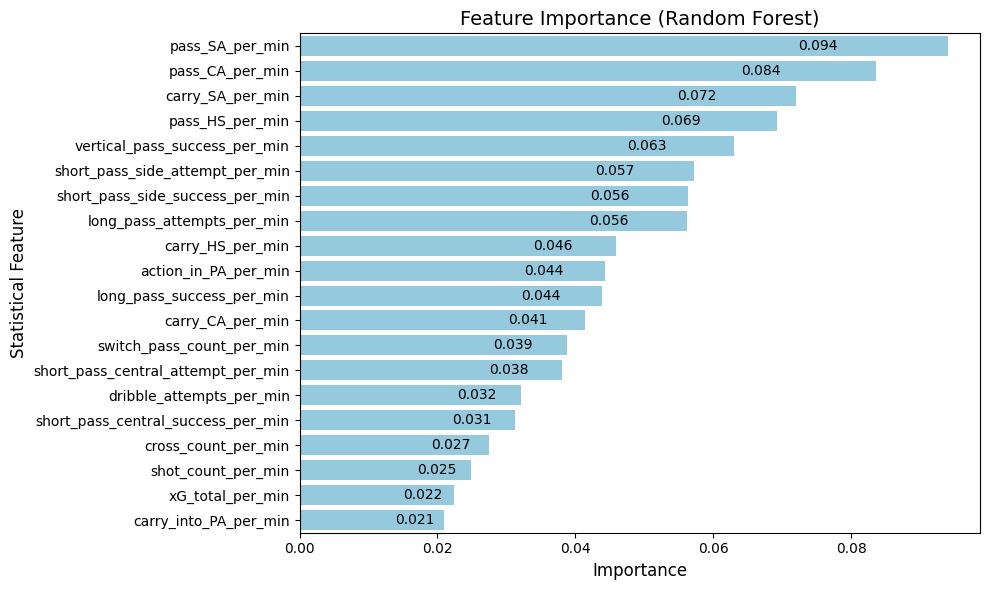

In [7]:
# Import necessary libraries / 必要なライブラリのインポート
import pandas as pd  # For handling data / データ操作用
import matplotlib.pyplot as plt  # For plotting / グラフ描画用
import seaborn as sns  # For heatmap and barplot / 可視化用

# Get feature importances from trained Random Forest model
# ランダムフォレストモデルから特徴量の重要度を取得
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display top 20 important features
# 特徴量の重要度（上位20項目）を表示
print("Top 20 Feature Importances / 特徴量の重要度（上位20）:")
print(importances.head(20))

# Visualize feature importances using barplot
# 特徴量の重要度を棒グラフで可視化（英語表記＋数値を棒の中に表示）
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=importances.head(20).values, y=importances.head(20).index, color='skyblue')

plt.title("Feature Importance (Random Forest)", fontsize=14)  # グラフタイトル
plt.xlabel("Importance", fontsize=12)  # x軸ラベル
plt.ylabel("Statistical Feature", fontsize=12)  # y軸ラベル

# Add value labels inside bars
# 数値ラベルを棒の中に表示（中央寄せ）
for i, (value, name) in enumerate(zip(importances.head(20).values, importances.head(20).index)):
    ax.text(value * 0.8, i, f"{value:.3f}", va='center', ha='center', color='black', fontsize=10)

plt.tight_layout()  # レイアウト調整
plt.show()  # グラフ表示